In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import IPython.display
IPython.display.display(IPython.display.HTML("<style>.container { width:90% !important; }</style>"))

sys.path.append('./../src/')
from manuscript import flow_sankey as sankey
from manuscript import datasets, inout, export


import itertools
import scipy.stats
import statsmodels.stats.multitest
import statannotations.Annotator

pd.options.display.max_columns = 200
mpl.rcParams["figure.figsize"] = (10, 8)
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["font.family"] = "Arial"

fonts = inout.get_resource_path('fonts')
for f in os.listdir(fonts):
    if f.endswith(".ttf"):
        mpl.font_manager.fontManager.addfont(f"{fonts}/{f}")
        
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"


def dump_table(df, name):
    export.full_frame(
        user, 
        f'{outfolder}/{name}', 
        df, 
        index=True,
        date=True
    )

def dump_figure(name):
    export.image(
        user,
        f'{outfolder}/{name}',
    )

In [2]:
DISCH_PALETTE = [
    "tab:blue", #home
    "lightseagreen", #rehab
    "beige", #snf
    "gold",#ltach
    "orange",#hospice
    "crimson",#died 
]

In [3]:
user = 'general'     # defines top hierarchy of output folder
outfolder = '10_VAP_transitions'    # name of notebook

In [4]:
data = pd.read_csv(
    inout.get_material_path('general/05_join_clusters_umap/05_data_umap_clusters_220908_1554.csv.gz'), 
    index_col=0
)

In [5]:
# match old naming

data.Binary_outcome.replace({1: "Died", 0: 'Alive'}, inplace=True)

data.Discharge_disposition = data.Discharge_disposition.astype("category")
data.Discharge_disposition = data.Discharge_disposition.cat.reorder_categories([
    'Home', 
    'Rehab', 
    'SNF', 
    'LTACH',
    'Hospice', 
    'Died'
])

data = data.rename(columns={
    'Patient_id': 'patient',
    'ICU_stay': 'stay',
    'ICU_day': 'day',
    'clusters': 'cluster'
})

# Ensure order
data.sort_values(["patient", "stay", "day"], inplace=True)

## Create intermediate data

A dataframe for each day around each VAP episode: in which clusters were the patients.

At the same time, check if any other pneumonia episode is overlapping

In [6]:
dfs = []
for day in range(-2, 8):
    days = data.day[data.Episode_category.eq("VAP") & data.Episode_etiology.ne("Viral")] + day
    days = days[days > 0]
    idx = (
        data.patient[days.index].astype(str) 
        + "/" + data.stay[days.index].astype(str) 
        + "/" + days.astype(str)
    )
    idx = idx[idx.isin(data.index)]
    df = pd.DataFrame({
        "cluster": data.cluster[idx].values,
        "next_cluster": data.next_cluster[idx].values,
        "episode_type": data.Episode_category[idx.index].values,
        "day": day
    }, index=idx.index)
    if day != 0:
        overlapping = data.loc[idx, ["Episode_category"]]
        overlapping["current_ep"] = idx.index.values
        overlapping = overlapping.loc[overlapping.Episode_category.isin(["CAP", "HAP", "VAP"]), :]
        if overlapping.shape[0] > 0:
            n_overlapping = (~overlapping.Episode_category.isna()).sum()
            print(f"{n_overlapping} overlapping episodes on day {day}")
            for i, row in overlapping.iterrows():
                print(f"On day {day} of {row.current_ep} VAP episode there was {i} episode")
            print()
    full_idx = data.index[data.Episode_category.eq("VAP") & data.Episode_etiology.ne("Viral")]
    df = df.reindex(full_idx)
    df.loc[full_idx[~full_idx.isin(idx.index)], "day"] = day
    df.loc[full_idx[~full_idx.isin(idx.index)], "episode_type"] = "VAP"
    df.loc[full_idx, "cured"] = data.Episode_is_cured[full_idx]
    df.loc[full_idx, "patient"] = data.patient[full_idx]
    df.loc[full_idx, "stay"] = data.stay[full_idx]
    df.loc[full_idx, "outcome"] = data.Binary_outcome[full_idx]
    dfs.append(df)
df = pd.concat(dfs)

1 overlapping episodes on day 7
On day 7 of 887/1/13 VAP episode there was 887/1/20 episode



In [7]:
df.shape

(2790, 8)

# Does Cured VAP lead to significantly favorable transitions?

We will take all VAP episodes, and summarize transition deltas from day 0 to day X (7 or before).

Do it for 3 cured categories, and test statistical differences

#### Add mortality data

In [8]:
df.loc[df.next_cluster.eq(-1), "next_cluster"] = np.nan

In [9]:
cluster_mortality = pd.read_csv(
    inout.get_material_path('general/04_clustering/Similarity-cluster_mortality_220908_1540.csv.gz'), 
    index_col=0
)

In [10]:
cluster_mortality['clusters'] = cluster_mortality['index'] + 1

In [11]:
cluster_mortality = cluster_mortality[['clusters', 'mortality']]

In [12]:
cluster_mortality = cluster_mortality.set_index("clusters")

In [13]:
df.loc[~df.cluster.isna(), "mortality"] = cluster_mortality.mortality[df.cluster[~df.cluster.isna()]].values

In [14]:
df.loc[~df.next_cluster.isna(), "next_mortality"] = cluster_mortality.mortality[
    df.next_cluster[~df.next_cluster.isna()]
].values

In [15]:
df.loc[
    df.next_cluster.isna() & df.outcome.eq("Alive"),
    "next_mortality"
] = 0

In [16]:
df.loc[
    df.next_cluster.isna() & df.outcome.eq("Died"),
    "next_mortality"
] = 1

In [17]:
df = df.loc[df.day >= 0].copy()

In [18]:
df["mortality_delta"] = df.next_mortality - df.mortality

In [19]:
df.mortality_delta.fillna(0, inplace=True)

In [20]:
df["episode_start"] = df.index

In [21]:
def vap_transitions(df, day):
    df = df.loc[df.day <= day]
    stat_df = df.groupby(["cured", "episode_start"]).mortality_delta.sum().reset_index()
    stat_results = []
    for d1, d2 in itertools.combinations(stat_df.cured.unique(), 2):
        days1 = stat_df.mortality_delta[stat_df.cured.eq(d1)]
        days2 = stat_df.mortality_delta[stat_df.cured.eq(d2)]
        if days1.size == 0 or days2.size == 0:
            continue
        pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
        stat_results.append([d1, d2, days1.size, days2.size, pval])
    stat_results = pd.DataFrame(stat_results, columns=["group1", "group2",
                                                       "group1_size", "group2_size", "pval"])
    stat_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stat_results.pval, alpha=0.05)[1]
    stat_results_sign = stat_results.loc[stat_results.pval_adj < 0.05, :]
    pairs = []
    for _, r in stat_results_sign.iterrows():
        pairs.append((r.group1, r.group2))
    
    fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
    sns.boxplot(
        data=stat_df, 
        x="cured",
        y="mortality_delta", 
        ax=ax, 
        saturation=1, 
        palette=[DISCH_PALETTE[0], DISCH_PALETTE[3], DISCH_PALETTE[-1]],
        linewidth=1
    )
    for a in ax.collections:
        if isinstance(a, mpl.collections.PatchCollection):
            # remove line surround each box
            a.set_linewidth(0)
    ax.set_ylabel("Sum of transitions", size=16)
    ax.set_xlabel("")
    ax.tick_params(axis="x", labelsize=14)
    # ax.set_xticklabels(["non-COVID", "COVID"], size=16)
    # ax.legend(loc="upper left", title="Outcome", frameon=False, fontsize=14, title_fontsize=12)
    # ax.legend_.set_bbox_to_anchor((1, 0.8))
    ax.set_title(f"Distribution of sum of transitions for first {day} days after episode", size=16)
    annotator = statannotations.Annotator.Annotator(
        ax, 
        pairs, 
        data=stat_df, 
        x="cured",
        y="mortality_delta", 
        verbose=False
    )
    annotator._verbose = False
    annotator.configure(line_width=1)
    annotator.set_custom_annotations([f"q={x:.2e}".replace("-", "–") for x in stat_results_sign.pval_adj])
    annotator.annotate();
    return ax

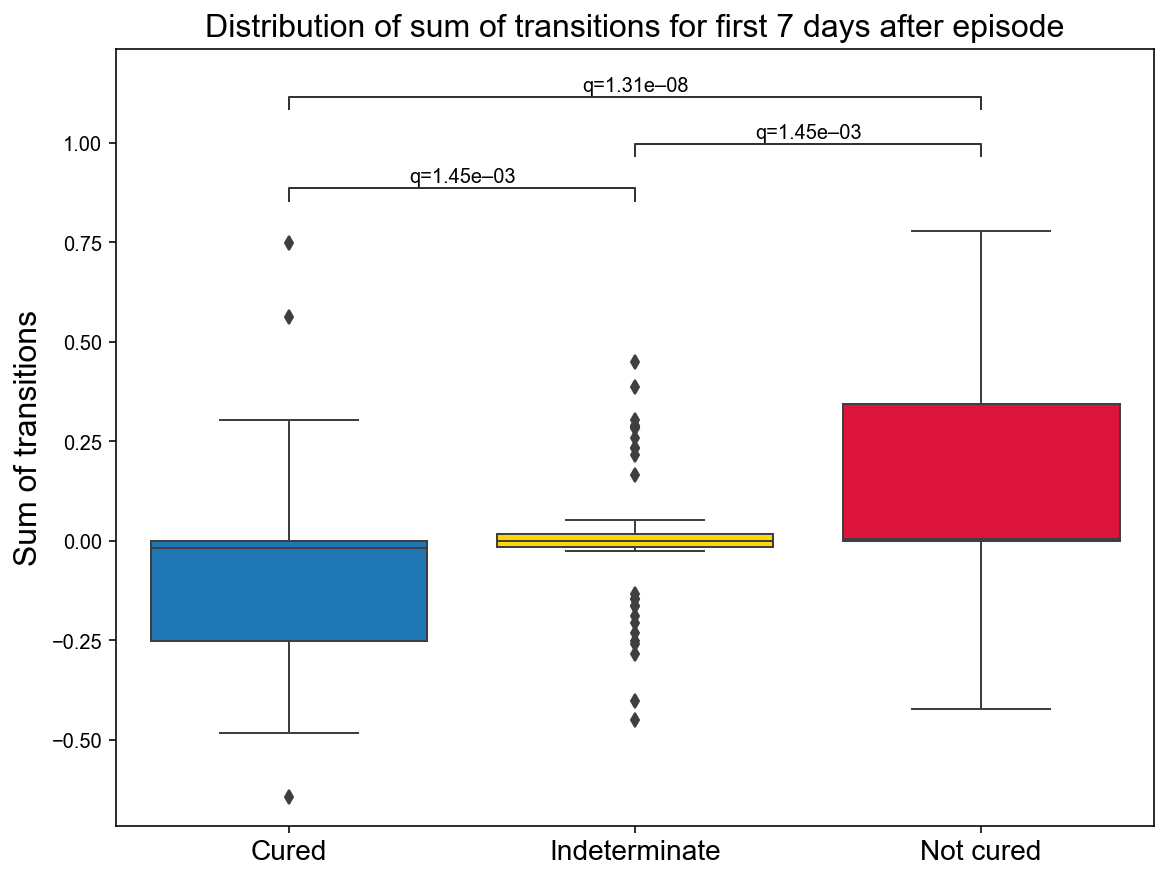

In [22]:
vap_transitions(df, 7)
dump_figure("vap_sum_of_trans_7days.pdf")

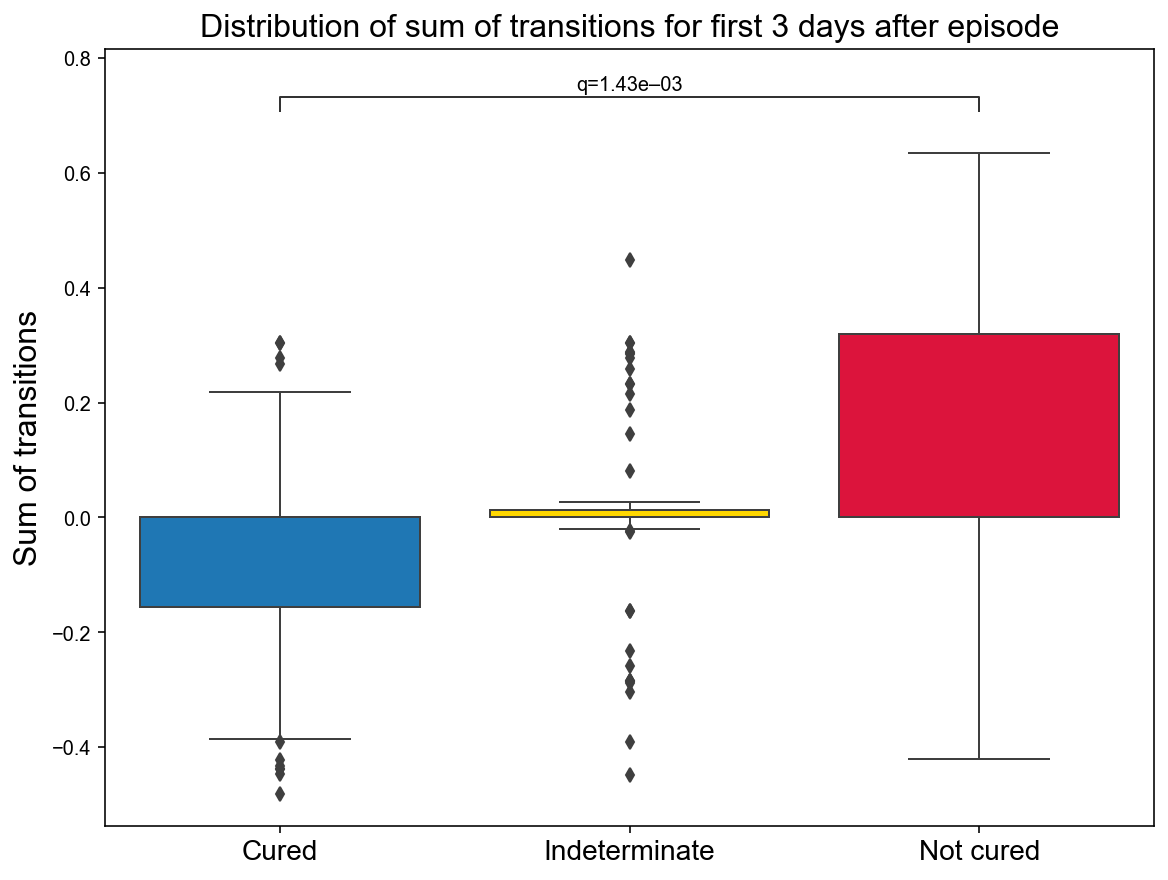

In [23]:
vap_transitions(df, 3)
dump_figure("vap_sum_of_trans_3days.pdf")

<AxesSubplot:title={'center':'Distribution of sum of transitions for first 4 days after episode'}, ylabel='Sum of transitions'>

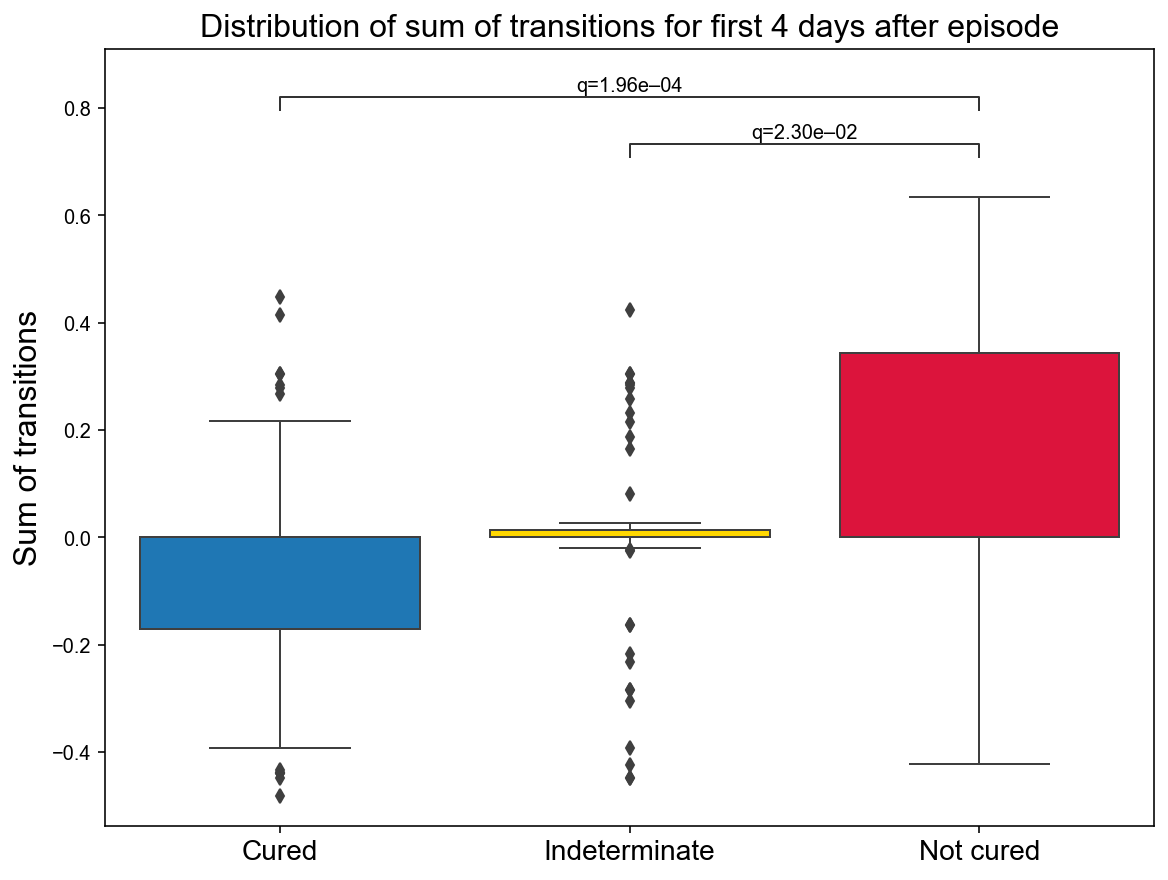

In [24]:
vap_transitions(df, 4)

<AxesSubplot:title={'center':'Distribution of sum of transitions for first 5 days after episode'}, ylabel='Sum of transitions'>

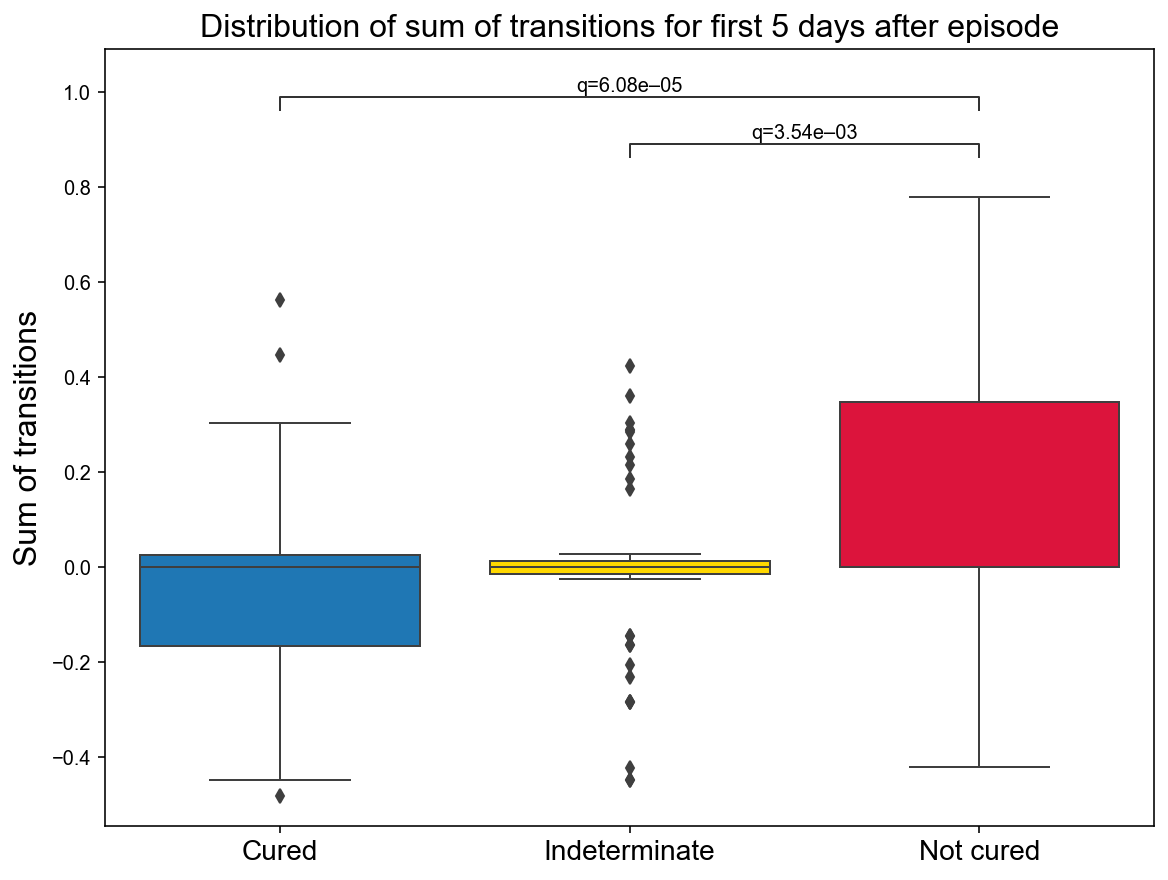

In [25]:
vap_transitions(df, 5)

<AxesSubplot:title={'center':'Distribution of sum of transitions for first 6 days after episode'}, ylabel='Sum of transitions'>

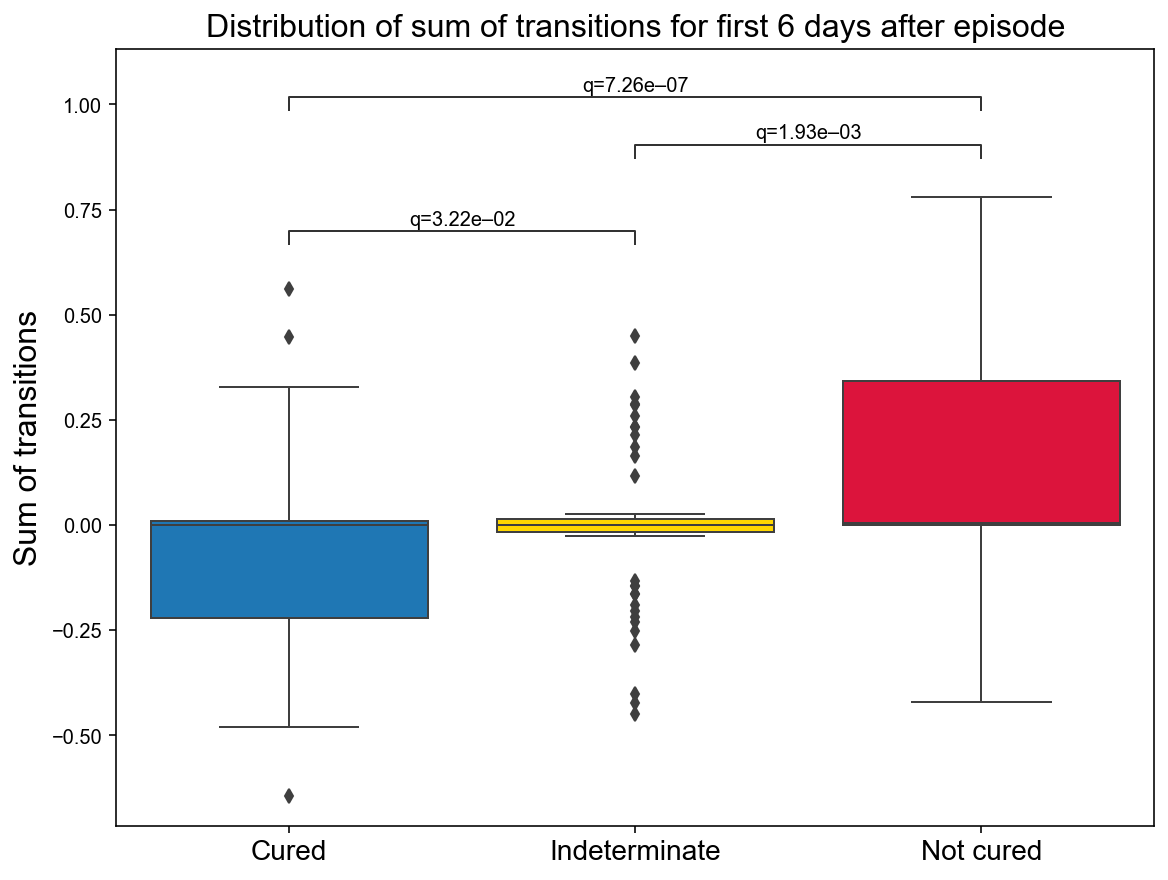

In [26]:
vap_transitions(df, 6)